# For Colab

In [1]:
# --- always get latest repo state in Colab ---
import os, sys, subprocess

REPO_URL  = "https://github.com/Wmeesena/Safe_Start.git"
REPO_ROOT = "/content/Safe_Start"     # repo root
WORKDIR   = os.path.join(REPO_ROOT, "MAGIC")
BRANCH    = "main"

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

if not os.path.isdir(REPO_ROOT):
    run(["git", "clone", "--depth", "1", "--branch", BRANCH, REPO_URL, REPO_ROOT])
else:
    run(["git", "-C", REPO_ROOT, "fetch", "origin"])
    run(["git", "-C", REPO_ROOT, "checkout", BRANCH])
    run(["git", "-C", REPO_ROOT, "reset", "--hard", f"origin/{BRANCH}"])

# (optional) submodules
# run(["git", "-C", REPO_ROOT, "submodule", "update", "--init", "--recursive"])

# Set working dir and import path
os.chdir(WORKDIR if os.path.isdir(WORKDIR) else REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())
!git -C {REPO_ROOT} rev-parse --abbrev-ref HEAD
!git -C {REPO_ROOT} rev-parse HEAD

# installs
%pip install -q ucimlrepo


$ git clone --depth 1 --branch main https://github.com/Wmeesena/Safe_Start.git /content/Safe_Start
CWD: /content/Safe_Start/MAGIC
main
b295647153e06c1660ce4c6bf0cdcc0b688b9665


# Setup

In [64]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import torch
from src.models.mlp import MLP
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from src.train import pretrain,  joint_train, train_all
from src.eval import evaluate_avg_accuracy, evaluate_robust, eval_one, eval_all
from src.utils import pct, pct_ci
from src.plots import plot_loss_multi, plot_all_loss
from src.data import load_magic_data

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import gc, torch
# gc.collect()
# torch.cuda.empty_cache()  # frees cached blocks back to the allocator

# Data

In [66]:
SIGMA = 10.0
SAMPLES_EVAL = 500000
SAMPLES_TRAIN = 100000
GAMMA = 10000.
NUM_EPOCHS = 100
NUM_EPOCHS_PRE = 100

In [67]:
X_train, y_train, X_test, y_test = load_magic_data()

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([14000, 10]),
 torch.Size([14000, 1]),
 torch.Size([5020, 10]),
 torch.Size([5020, 1]))

# Pretrain

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model = MLP(input_size=X_train.shape[1]).to(device)
pre_model = pretrain(X_train,y_train, model, num_epochs=NUM_EPOCHS_PRE)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
pre_model = MLP(input_size=X_train.shape[1]).to(device)

In [36]:
_ = eval_one(
    pre_model, X_test, y_test,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)


Accuracy: 39.48%  (CI 95%: [38.14%, 40.84%])
Robust Accuracy: 39.49327%  (CI 95%: [38.07385%, 40.69772%])
Conditional Robust Accuracy: 99.59143%  (CI 95%: [99.43352%, 99.71703%])


In [9]:
# pre_model1, hist_pre1 = joint_train(
#             X_train, y_train, pre_model, num_epochs=1, gamma=GAMMA,
#             num_samples=SAMPLES_TRAIN, sigma=SIGMA, IF_SAFE=False,
#             opt="adam"
#         )
# _ = eval_one( pre_model1, X_test, y_test, SIGMA, 1000)

In [71]:
# minimal test of "can a single split classify MAGIC?"
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# your function
X_train, y_train, X_test, y_test = load_magic_data()

# --- convert Torch tensors to numpy (and fix shape of y) ---
Xtr = X_train.detach().cpu().numpy()
Ytr = y_train.detach().cpu().numpy().reshape(-1)
Xte = X_test.detach().cpu().numpy()
Yte = y_test.detach().cpu().numpy().reshape(-1)

# sanity: show class balance
unique, counts = np.unique(Ytr, return_counts=True)
print("Train class balance:", dict(zip(unique, counts)))
unique, counts = np.unique(Yte, return_counts=True)
print("Test  class balance:", dict(zip(unique, counts)))

def fit_and_eval(name, **tree_kwargs):
    clf = DecisionTreeClassifier(random_state=42, **tree_kwargs)
    clf.fit(Xtr, Ytr)
    ypred = clf.predict(Xte)
    acc = accuracy_score(Yte, ypred)
    print(f"\n{name}: test accuracy = {acc:.4f}")
    # show the tiny tree
    try:
        print(export_text(clf, feature_names=[f"x{j}" for j in range(Xtr.shape[1])]))
    except Exception:
        pass
    return acc, clf

# 1) Decision stump (single split)
acc1, stump = fit_and_eval("Decision stump (max_depth=1)", max_depth=1)

# 2) (Optional) try a couple of slightly larger but still tiny trees
acc2, t2 = fit_and_eval("Very small tree (max_depth=2)", max_depth=2, min_samples_leaf=20)
acc3, t3 = fit_and_eval("Small tree (max_depth=3)", max_depth=3, min_samples_leaf=50)

# quick confusion matrix for the stump
from pprint import pprint
cm = confusion_matrix(Yte, stump.predict(Xte))
print("\nConfusion matrix (stump):")
pprint(cm)

print("\nClassification report (stump):")
print(classification_report(Yte, stump.predict(Xte), digits=4))


Train class balance: {0.0: 4879, 1.0: 9121}
Test  class balance: {0.0: 1809, 1.0: 3211}

Decision stump (max_depth=1): test accuracy = 0.7339
|--- x8 <= 26.19
|   |--- class: 1.0
|--- x8 >  26.19
|   |--- class: 0.0


Very small tree (max_depth=2): test accuracy = 0.7926
|--- x8 <= 26.19
|   |--- x0 <= 116.18
|   |   |--- class: 1.0
|   |--- x0 >  116.18
|   |   |--- class: 0.0
|--- x8 >  26.19
|   |--- x0 <= 31.15
|   |   |--- class: 1.0
|   |--- x0 >  31.15
|   |   |--- class: 0.0


Small tree (max_depth=3): test accuracy = 0.7926
|--- x8 <= 26.19
|   |--- x0 <= 116.18
|   |   |--- x8 <= 9.67
|   |   |   |--- class: 1.0
|   |   |--- x8 >  9.67
|   |   |   |--- class: 1.0
|   |--- x0 >  116.18
|   |   |--- x8 <= 8.69
|   |   |   |--- class: 0.0
|   |   |--- x8 >  8.69
|   |   |   |--- class: 0.0
|--- x8 >  26.19
|   |--- x0 <= 31.15
|   |   |--- x2 <= 2.32
|   |   |   |--- class: 1.0
|   |   |--- x2 >  2.32
|   |   |   |--- class: 1.0
|   |--- x0 >  31.15
|   |   |--- x0 <= 54.91
|   

# Training

In [21]:
results = train_all(X_train, y_train,pre_model, NUM_EPOCHS, GAMMA, SAMPLES_TRAIN, SIGMA, opts =["sgd"] )


Training naive with adam...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[epoch 010] loss=1.2263 | avg=1.0487 | rare=0.0000
[epoch 020] loss=1.2453 | avg=0.9686 | rare=0.0000
[epoch 030] loss=1.2123 | avg=0.8582 | rare=0.0000
[epoch 040] loss=1.0680 | avg=0.6971 | rare=0.0000
[epoch 050] loss=0.9799 | avg=0.5025 | rare=0.0000
[epoch 060] loss=0.7619 | avg=0.4971 | rare=0.0000
[epoch 070] loss=0.6845 | avg=0.4835 | rare=0.0000
[epoch 080] loss=0.6878 | avg=0.4911 | rare=0.0000
[epoch 090] loss=0.6433 | avg=0.4987 | rare=0.0000
[epoch 100] loss=0.7621 | avg=0.5224 | rare=0.0000

Training safe with adam...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[epoch 010] loss=10.6774 | avg=7.9644 | rare=0.0003
[epoch 020] loss=10.8219 | avg=5.4391 | rare=0.0005
[epoch 030] loss=9.1332 | avg=5.2764 | rare=0.0004
[epoch 040] loss=8.3197 | avg=5.1016 | rare=0.0003
[epoch 050] loss=8.2896 | avg=4.8858 | rare=0.0003
[epoch 060] loss=10.0686 | avg=4.5234 | rare=0.0006
[epoch 070] loss=10.0258 | avg=4.3930 | rare=0.0006
[epoch 080] loss=9.3129 | avg=4.5492 | rare=0.0005
[epoch 090] loss=11.1808 | avg=4.5968 | rare=0.0007
[epoch 100] loss=10.8366 | avg=5.1515 | rare=0.0006

Training safe_neg with adam...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[epoch 010] loss=52.1748 | avg=50.0464 | rare=0.0002
[epoch 020] loss=41.3283 | avg=34.8160 | rare=0.0007
[epoch 030] loss=50.0816 | avg=43.6136 | rare=0.0006
[epoch 040] loss=55.7622 | avg=44.4547 | rare=0.0011
[epoch 050] loss=64.9639 | avg=52.4654 | rare=0.0012
[epoch 060] loss=75.7699 | avg=51.1251 | rare=0.0025
[epoch 070] loss=83.9104 | avg=54.8228 | rare=0.0029
[epoch 080] loss=96.0435 | avg=59.1027 | rare=0.0037
[epoch 090] loss=106.6515 | avg=66.6609 | rare=0.0040
[epoch 100] loss=125.0523 | avg=62.3124 | rare=0.0063


# Results

## Loss Trajectories

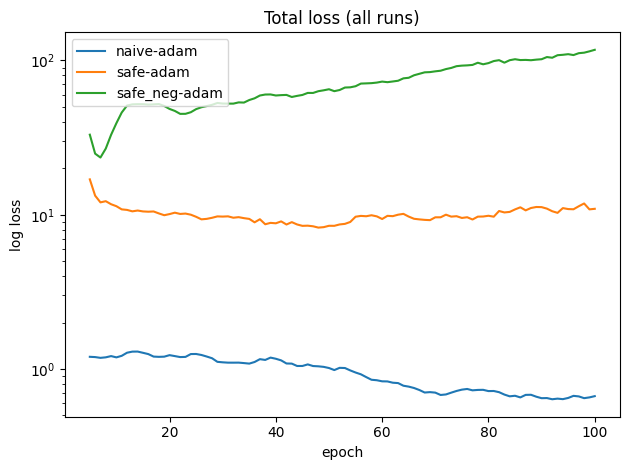

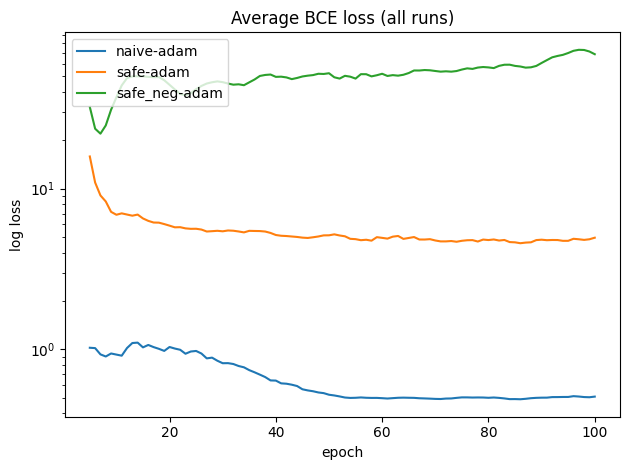

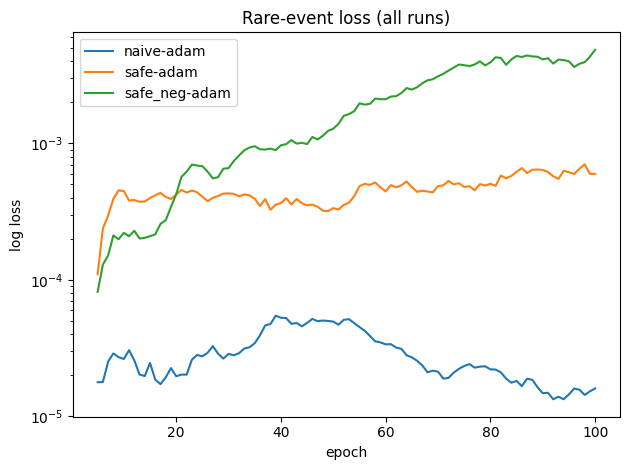

In [22]:
plot_all_loss(results, show_log=True)

## Accuracies

In [ ]:
# _ = eval_all(results, X_test, y_test, SIGMA, SAMPLES_EVAL)

Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.96415%  (CI 95%: [62.80876%, 65.35857%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 68.96%  (CI 95%: [67.67%, 70.23%])
Robust Accuracy: 69.33267%  (CI 95%: [68.13745%, 70.59811%])
Conditional Robust Accuracy: 98.88793%  (CI 95%: [98.59908%, 99.14789%])
Accuracy: 36.04%  (CI 95%: [34.72%, 37.37%])
Robust Accuracy: 35.98606%  (CI 95%: [34.60134%, 37.16160%])
Conditional Robust Accuracy: 99.86180%  (CI 95%: [99.72360%, 99.97236%])
Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.98407%  (CI 95%: [62.80876%, 65.35906%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.96415%  (CI 95%: [62.80876%, 65.35857%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 36.04%  (CI 95%: [34.72%, 37.37%])
Robust Accuracy: 36.03586%  (CI 95%: [34.64143%, 37

In [23]:
_ = eval_one(
    pre_model, X_train, y_train,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)

Accuracy: 38.09%  (CI 95%: [37.28%, 38.89%])
Robust Accuracy: 38.10764%  (CI 95%: [37.34945%, 38.85495%])
Conditional Robust Accuracy: 99.61535%  (CI 95%: [99.50762%, 99.70247%])


In [24]:
_ = eval_one(
    results[('naive', 'sgd')][0], X_train, y_train,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)

Accuracy: 82.06%  (CI 95%: [81.42%, 82.69%])
Robust Accuracy: 82.04451%  (CI 95%: [81.48105%, 82.67581%])
Conditional Robust Accuracy: 99.85071%  (CI 95%: [99.81083%, 99.88348%])


In [25]:
_ = eval_one(
    results[('safe', 'sgd')][0], X_train, y_train,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)

Accuracy: 79.88%  (CI 95%: [79.21%, 80.53%])
Robust Accuracy: 79.87707%  (CI 95%: [79.27505%, 80.51704%])
Conditional Robust Accuracy: 99.92183%  (CI 95%: [99.89304%, 99.94778%])


In [26]:
_ = eval_one(
    results[('safe_neg', 'sgd')][0], X_test, y_test,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=500,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)

Accuracy: 72.17%  (CI 95%: [70.91%, 73.39%])
Robust Accuracy: 72.19623%  (CI 95%: [71.03509%, 73.47996%])
Conditional Robust Accuracy: 99.86691%  (CI 95%: [99.79412%, 99.93123%])


In [ ]:
1+1